<a href="https://colab.research.google.com/github/Bane-24/Crypto-Price-Prediction/blob/main/Week_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installing required libraries
!pip install cryptocmd
!pip install yfinance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cryptocmd import CmcScraper
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import yfinance as yf
import tensorflow as tf
from tensorflow import keras

!pip install keras-tuner
import keras_tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.6 MB/s eta 0:00:00


<ipython-input-1-5712859aa970>:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


In [2]:
# Scrape cryptocurrency data
scraper = CmcScraper("BTC", "01-01-2014", "31-03-2023")
bitcoin_df = scraper.get_dataframe()

# Scrape stock market data
stock_data = yf.download("SPY", start="2014-01-01", end="2023-03-31")
stock_df = stock_data["Adj Close"].to_frame().reset_index().rename(columns={"Adj Close": "stock_price", "Date": "Date"})

# Create a date range that includes all dates between start and end dates
date_range = pd.date_range(start="2014-01-01", end="2023-03-31")
date_range_df = pd.DataFrame(date_range, columns=["Date"])

# Merge stock_df with the date_range_df
stock_df = stock_df.merge(date_range_df, on="Date", how="outer")
stock_df.sort_values("Date", inplace=True)


# Fill missing values using ffill and bfill methods
stock_df["stock_price"].fillna(method="bfill", inplace=True)
stock_df["stock_price"].fillna(method="ffill", inplace=True)


# Merge the filled stock_df with bitcoin_df
merged_df = bitcoin_df.merge(stock_df, on="Date", how="inner")
merged_df.set_index("Date", inplace=True)
merged_df.index = pd.to_datetime(merged_df.index)
merged_df.interpolate(method="time", inplace=True)

# Add day, week, and month columns
merged_df["day"] = merged_df.index.day
merged_df["week"] = merged_df.index.week
merged_df["month"] = merged_df.index.month
merged_df = merged_df.sort_values(by = ['Date'])

[*********************100%***********************]  1 of 1 completed


<ipython-input-2-9ed5ca8e5600>:31: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  merged_df["week"] = merged_df.index.week


In [3]:
# Normalize features separately
scaler_btc = MinMaxScaler()
merged_df["Close"] = scaler_btc.fit_transform(merged_df[["Close"]])
scaler_stock = MinMaxScaler()
merged_df["stock_price"] = scaler_stock.fit_transform(merged_df[["stock_price"]])

In [4]:
merged_df.head(7)

,Open,High,Low,Close,Volume,Market Cap,stock_price,day,week,month
Date,,,,,,,,,,
2014-01-01,754.969971,775.349976,754.969971,0.008804,22489400.0,9.403308e+09,0.022988,1,1,1
2014-01-02,773.440002,820.309998,767.210022,0.009264,38489500.0,9.781074e+09,0.022988,2,1,1
2014-01-03,802.849976,834.150024,789.119995,0.009506,37810100.0,9.980135e+09,0.022909,3,1,1
2014-01-04,823.270020,859.510010,801.669983,0.010112,38005000.0,1.047736e+10,0.021517,4,1,1
2014-01-05,858.549988,952.400024,854.520020,0.011210,72898496.0,1.137966e+10,0.021517,5,1,1
2014-01-06,936.049988,1017.119995,905.710022,0.011503,85565696.0,1.162053e+10,0.021517,6,2,1
2014-01-07,946.489990,965.739990,802.000000,0.009258,81311696.0,9.808300e+09,0.024460,7,2,1


In [5]:
# Calculate the number of weeks since the start of the data
merged_df['week_number'] = (merged_df.index - merged_df.index[0]).days // 7

# Calculate weekly averages
weekly_avg = merged_df.groupby('week_number').mean()
weekly_avg.drop(['day', 'week', 'month'], axis=1, inplace=True)


# Calculate the number of months since the start of the data
merged_df['month_number'] = ((merged_df.index.year - merged_df.index[0].year) * 12) + (merged_df.index.month - merged_df.index[0].month)

# Calculate monthly averages
monthly_avg = merged_df.groupby('month_number').mean()
monthly_avg.drop(['day', 'week', 'month', 'week_number'], axis=1, inplace=True)

In [6]:
weekly_avg.tail(7)

,Open,High,Low,Close,Volume,Market Cap,stock_price
week_number,,,,,,,
476,24074.887644,24915.028665,23724.333755,0.359290,3.122549e+10,4.706130e+11,0.794155
477,23718.815922,23922.283901,23224.945493,0.346592,2.334706e+10,4.542570e+11,0.776061
478,22836.684136,23032.813324,22485.083911,0.334258,1.938761e+10,4.383624e+11,0.786421
479,21639.657458,22640.759969,21151.922960,0.323839,3.657534e+10,4.249514e+11,0.749116
480,26346.731502,27336.079353,25910.242125,0.395474,4.037439e+10,5.183671e+11,0.766315
481,27699.229675,28198.604642,26986.916188,0.406564,2.097380e+10,5.329923e+11,0.772352
482,27883.145311,28806.447363,27521.178593,0.417113,2.070721e+10,5.468611e+11,0.796503


In [7]:
# Prepare data
def prepare_data(df, feature_columns, target_column, n_past, n_future):
    x_data, y_data = [], []
    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[feature_columns].iloc[i - n_past:i].values)
        y_data.append(df[target_column].iloc[i:i + n_future].values)
    return np.array(x_data), np.array(y_data)

In [9]:
# Split into train and test sets
# Set the train_date index
train_week_index = 420
n_past_week = 40
n_future = 1
feature_columns = ["Close", "stock_price"]
target_column = "Close"
x_data2, y_data2 = prepare_data(weekly_avg, feature_columns, target_column, n_past_week, n_future)


# Calculate the train_size based on the index
train_size_week = train_week_index - n_past_week

x_train2, x_test2 = x_data2[:train_size_week], x_data2[train_size_week:]
y_train2, y_test2 = y_data2[:train_size_week], y_data2[train_size_week:]

In [10]:
print("x_train shape:", x_train2.shape)
print("y_train shape:", y_train2.shape)
print("x_test shape:", x_test2.shape)
print("y_test shape:", y_test2.shape)

x_train shape: (380, 40, 2)
y_train shape: (380, 1)
x_test shape: (63, 40, 2)
y_test shape: (63, 1)


In [12]:
# LSTM & Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

def create_model(learning_rate=0.001, dropout_rate=0.2, neurons=50):
  model = Sequential()
  model.add(LSTM(neurons, activation="tanh", input_shape=(n_past_week, len(feature_columns)), return_sequences=True))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(neurons, activation="tanh", return_sequences=False))
  model.add(Dropout(dropout_rate))
  model.add(Dense(n_future))
  optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
  model.compile(optimizer=optimizer, loss="mse")
  return model

model = KerasRegressor(build_fn=create_model, verbose=0)

param_dist = {
    'batch_size': [32, 64],
    'epochs': [10],
    'learning_rate': [0.01, 0.001],
    'dropout_rate': [0.2, 0.4],
    'neurons': [25, 50]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(x_train2, y_train2)

<ipython-input-12-4dbbb2e3ef36>:17: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7ff4eb697ca0>,
                   n_jobs=-1,
                   param_distributions={'batch_size': [32, 64],
                                        'dropout_rate': [0.2, 0.4],
                                        'epochs': [10],
                                        'learning_rate': [0.01, 0.001],
                                        'neurons': [25, 50]},
                   random_state=42, verbose=2)

In [13]:
# Training the model
best_model = random_search.best_estimator_.model
best_model.fit(x_train2, y_train2, epochs=random_search.best_params_['epochs'], batch_size=random_search.best_params_['batch_size'])

Epoch 1/10
12/12 [==============================] - 1s 76ms/step - loss: 0.0054
Epoch 2/10
12/12 [==============================] - 1s 71ms/step - loss: 0.0044
Epoch 3/10
12/12 [==============================] - 1s 43ms/step - loss: 0.0041
Epoch 4/10
12/12 [==============================] - 1s 43ms/step - loss: 0.0036
Epoch 5/10
12/12 [==============================] - 1s 42ms/step - loss: 0.0038
Epoch 6/10
12/12 [==============================] - 1s 44ms/step - loss: 0.0040
Epoch 7/10
12/12 [==============================] - 1s 47ms/step - loss: 0.0030
Epoch 8/10
12/12 [==============================] - 1s 48ms/step - loss: 0.0029
Epoch 9/10
12/12 [==============================] - 1s 42ms/step - loss: 0.0036
Epoch 10/10
12/12 [==============================] - 1s 41ms/step - loss: 0.0036


In [14]:
# Make predictions
y_pred = best_model.predict(x_test2)

2/2 [==============================] - 1s 19ms/step


Mean Squared Error: 18772373.58
Mean Absolute Error: 3583.23
R2 Score: 0.76


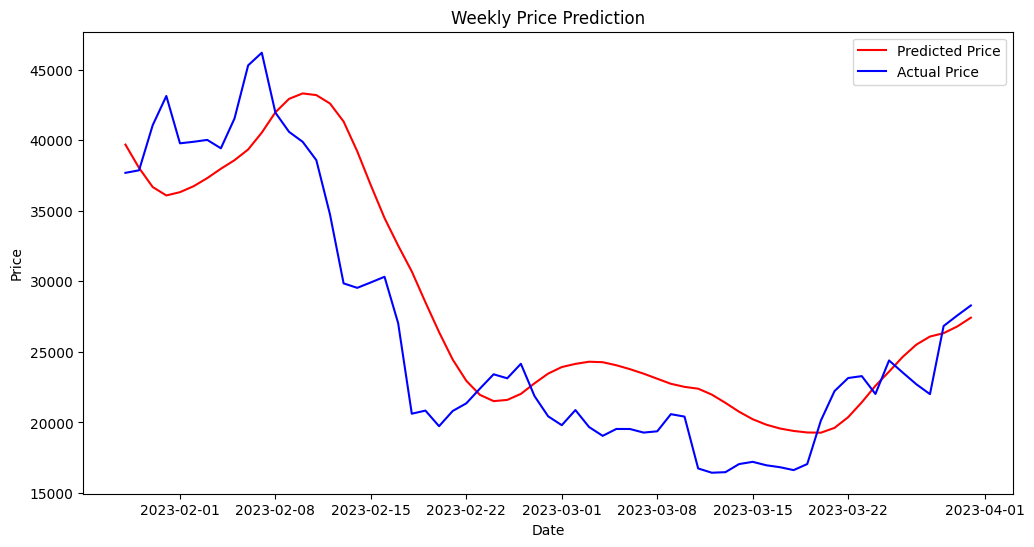

In [16]:
# Invert the scaling for predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred_actual = scaler_btc.inverse_transform(y_pred)
y_test_actual = scaler_btc.inverse_transform(y_test2)
# Evaluate the model
mse = mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print("Mean Squared Error: {:.2f}".format(mse))
print("Mean Absolute Error: {:.2f}".format(mae))
print("R2 Score: {:.2f}".format(r2))

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index[-len(y_pred_actual):], y_pred_actual, label="Predicted Price", color='r')
plt.plot(merged_df.index[-len(y_test_actual):], y_test_actual, label="Actual Price", color='b')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="best")
plt.title("Weekly Price Prediction")
plt.show()

1/1 [==============================] - 0s 78ms/step


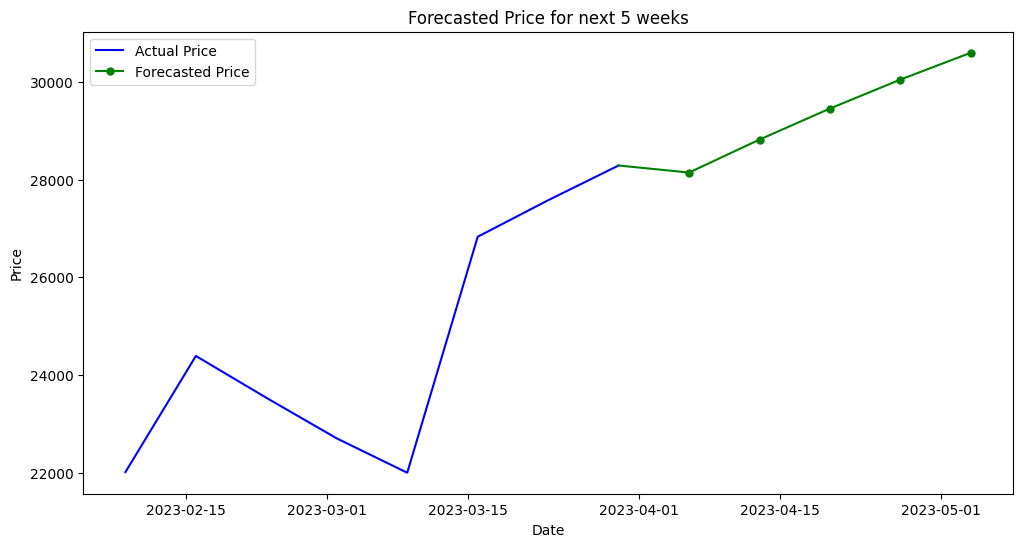

In [26]:
# Create dataframes for actual prices with dates as their index
actual_price_df = pd.DataFrame(scaler_btc.inverse_transform(weekly_avg[["Close"]]), index=weekly_avg.index, columns=["Actual Price"])

# Forecast for the next 5 weeks
x_forecast = weekly_avg[feature_columns].values[-n_past_week:]
forecasted_prices = []
forecasted_weeks = []

for i in range(5):
    x_forecast = x_forecast.reshape((1, n_past_week, len(feature_columns)))
    y_forecast = best_model.predict(x_forecast)
    forecasted_price_actual = scaler_btc.inverse_transform(y_forecast)
    forecasted_prices.append(forecasted_price_actual[0][0])
    next_week = weekly_avg.index[-1] + pd.DateOffset(weeks=i+1)
    forecasted_weeks.append(next_week)
    new_row = np.array([y_forecast[0][0], x_forecast[0][-1][1]])
    x_forecast = np.append(x_forecast, new_row)
    x_forecast = x_forecast[-n_past_week * len(feature_columns):].reshape((n_past_week, len(feature_columns)))

# Add the forecasted prices to a new dataframe
forecasted_price_df = pd.DataFrame(forecasted_prices, index=forecasted_weeks, columns=["Forecasted Price"])

# Limit the data to last three months
last_three_months = forecasted_price_df.index[-1] - pd.DateOffset(months=3)
actual_price_df_last_three_months = actual_price_df[last_three_months:]
forecasted_price_df_last_three_months = forecasted_price_df[last_three_months:]

# Visualize the last three months of actual vs forecasted data
plt.figure(figsize=(12, 6))
plt.plot(actual_price_df_last_three_months.index, actual_price_df_last_three_months["Actual Price"], label="Actual Price", color='b')
plt.plot(forecasted_price_df_last_three_months.index, forecasted_price_df_last_three_months["Forecasted Price"], label="Forecasted Price", color='g', marker='o', markersize=5)

# Joining the forecasted line with the actual prices
last_actual_price = actual_price_df_last_three_months["Actual Price"].iloc[-1]
first_forecasted_price = forecasted_price_df_last_three_months["Forecasted Price"].iloc[0]
plt.plot([actual_price_df_last_three_months.index[-1], forecasted_price_df_last_three_months.index[0]], [last_actual_price, first_forecasted_price], color='g')

plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="best")
plt.title("Forecasted Price for next 5 weeks")
plt.show()